## Baselines
1) Average velocity (delta x, delta y) as a constant for all future (5) timepoints  
2) Last velocity (delta x, delta y) as a constant  
3) Discounted average velocity as a constant  
4) Average acceleration (delta delta x, y)  
5) Last acceleration  
6) Discounted average acceleration  
7) Average velocity + average rotation

In [53]:
from matplotlib import pyplot as plt
import numpy as np
import math

## Data preprocessing

In [4]:
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.77it/s]


Warning! too big dt in [Edinburgh]
finish


## Helper functions

In [57]:
# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

def plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.scatter(pred_x, pred_y, color='r')
    
    plt.plot(np.append(sample_x, test_x), np.append(sample_y, test_y), label="actual data", color='g')
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y, test_y), color='g')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    plt.scatter(pred_x[0], pred_y[0], color='r')

    plt.show()
    
def plot_whole_trajectories(sample_x, sample_y, pred_x, pred_y, random_start_idx):
    plt.figure(figsize=(8, 8))
    plt.axes().set_aspect('equal')
        
    plt.plot(sample_x, sample_y, color='g', linewidth=2)
    plt.scatter(sample_x, sample_y, color='g', linewidth=2)

    plt.plot(pred_x, pred_y, color='r')
    plt.scatter(pred_x, pred_y, color='r')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    
    plt.plot(sample_x[random_start_idx:random_start_idx+5], sample_y[random_start_idx:random_start_idx+5], c='yellow')
    plt.scatter(sample_x[random_start_idx:random_start_idx+5], sample_y[random_start_idx:random_start_idx+5], c='yellow')

    plt.show()
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

# Experiments

### 1) Average delta x, delta y as a constant for all future (5) timepoints

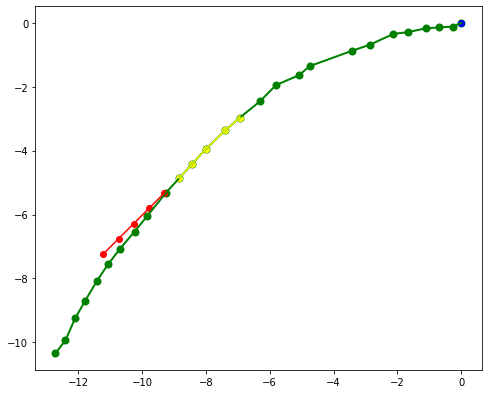

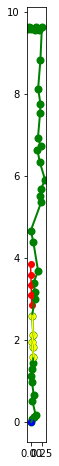

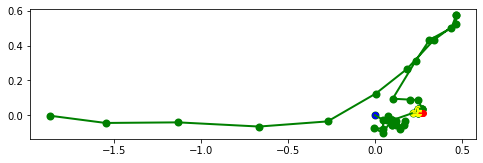

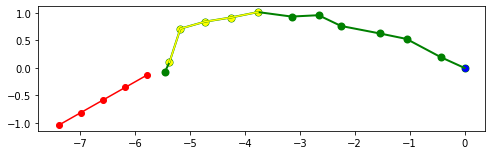

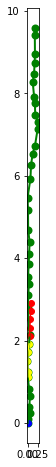

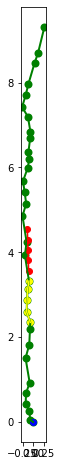

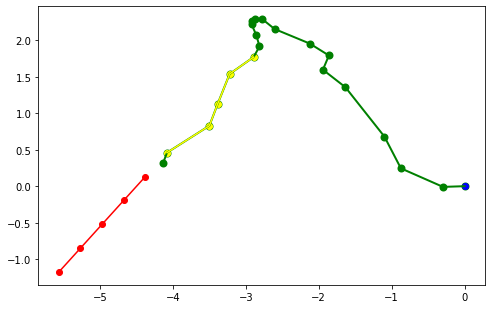

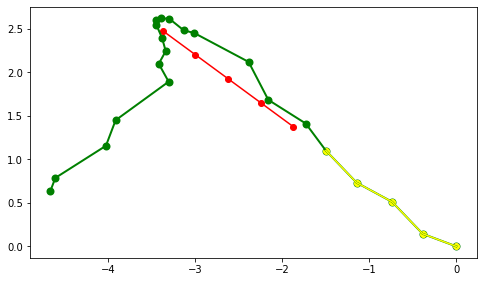

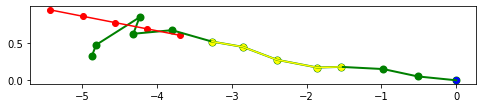

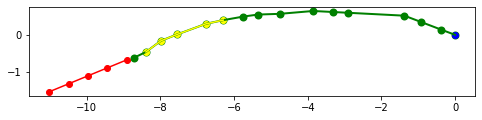

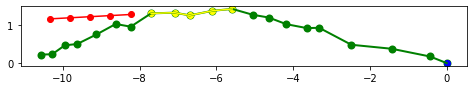

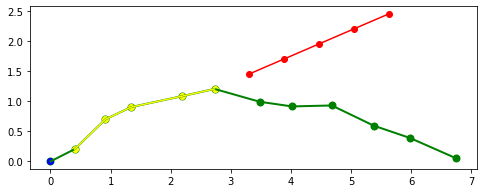

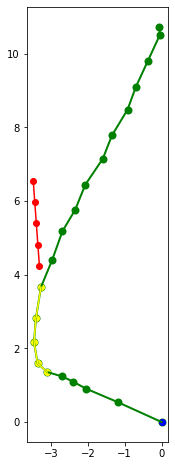

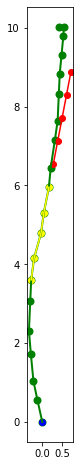

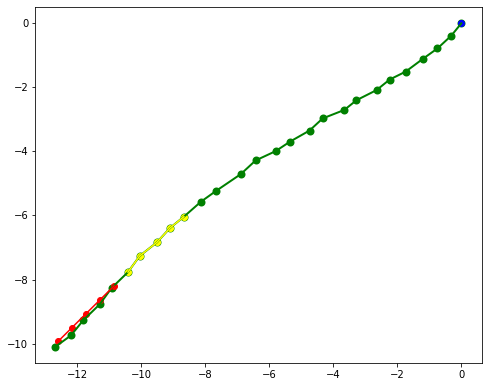

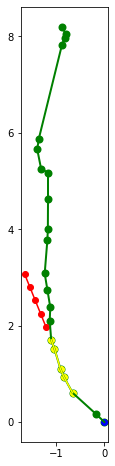

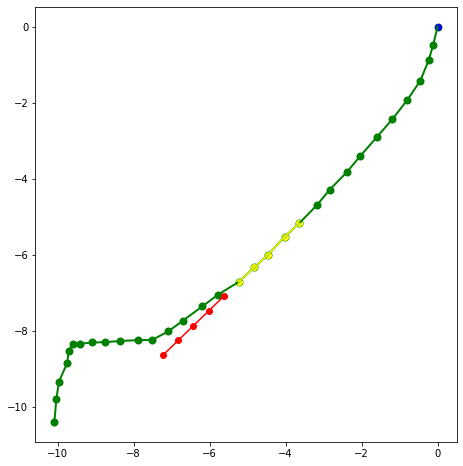

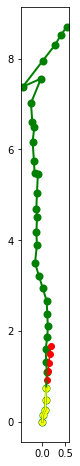

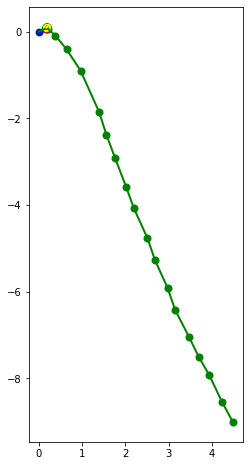

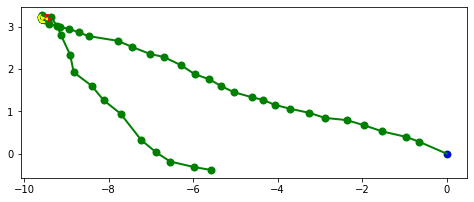

In [50]:
for agent_id in agent_ids[:20]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 2) Last delta x, delta y as a constant

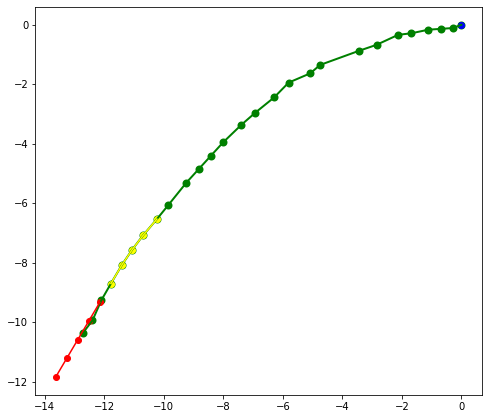

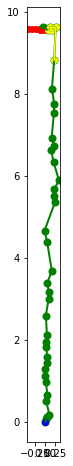

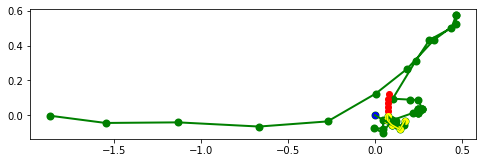

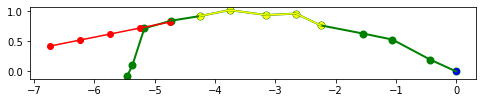

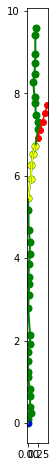

In [43]:
for agent_id in agent_ids[:5]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + i*last_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*last_vel_y for i in range(1, 6)]
    
    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 3) Discounted delta x, y as constant

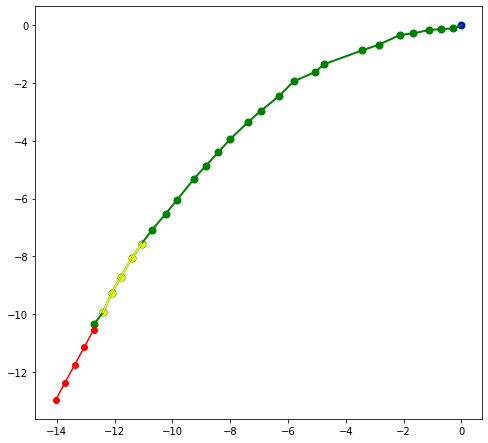

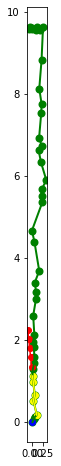

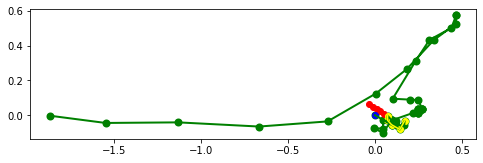

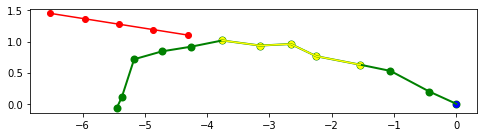

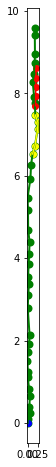

In [44]:
for agent_id in agent_ids[:5]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    disc_avg_x = (0.8**3*sample_vel_x[0] + 0.8**2*sample_vel_x[1] + 0.8*sample_vel_x[2] + sample_vel_x[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
    disc_avg_y = (0.8**3*sample_vel_y[0] + 0.8**2*sample_vel_y[1] + 0.8*sample_vel_y[2] + sample_vel_y[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
    
    pred_x = [sample_x[-1] + i*disc_avg_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*disc_avg_y for i in range(1, 6)]
    
    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 4) Average acceleration model (delta delta x, y)

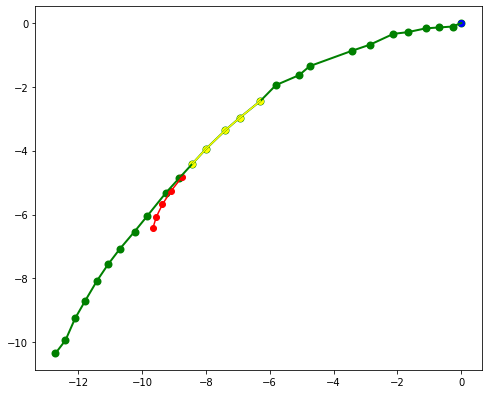

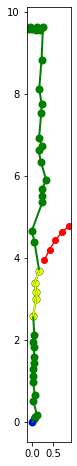

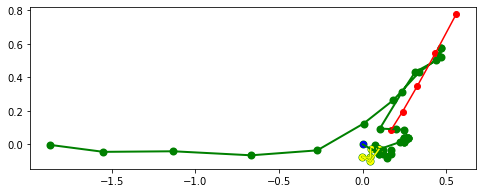

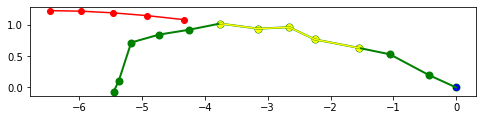

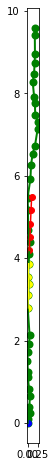

In [45]:
for agent_id in agent_ids[:5]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    avg_acceleration_x = np.mean(sample_acceleration_x)
    avg_acceleration_y = np.mean(sample_acceleration_y)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + avg_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + avg_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * avg_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * avg_acceleration_y)


    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 5) Last acceleration model

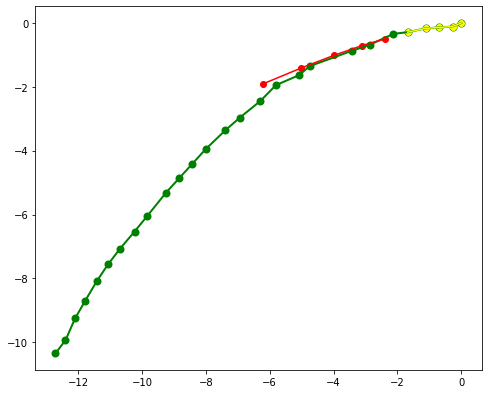

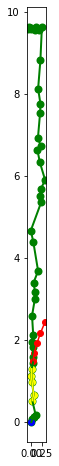

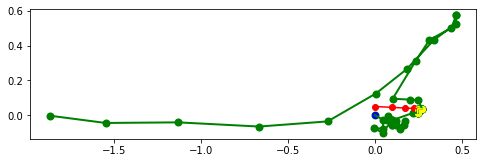

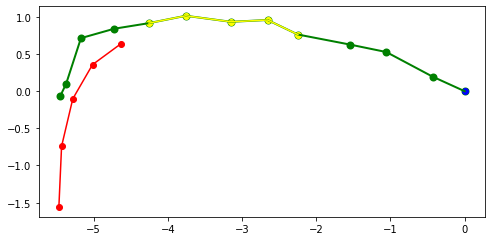

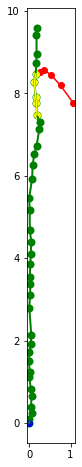

In [46]:
for agent_id in agent_ids[:5]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    last_acceleration_x = sample_acceleration_x[-1]
    last_acceleration_y = sample_acceleration_y[-1]
    
    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + last_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + last_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * last_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * last_acceleration_y)

    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 6) Discounted average acceleration 

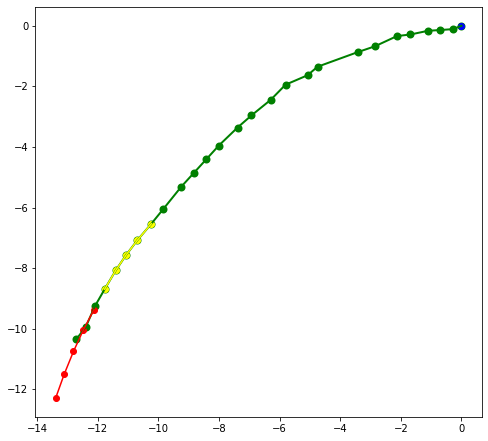

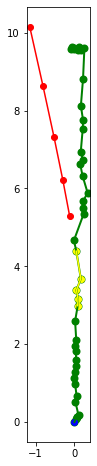

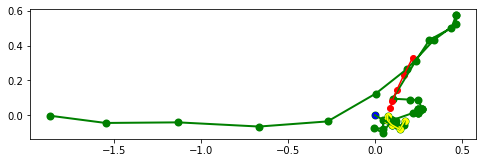

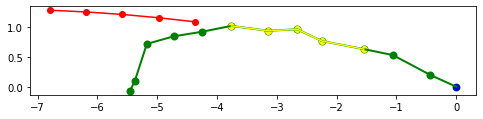

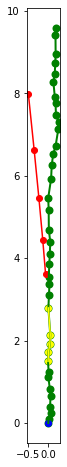

In [47]:
for agent_id in agent_ids[:5]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_speed_x = np.mean(sample_vel_x)
    avg_speed_y = np.mean(sample_vel_y)
    
    sample_acc_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acc_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    discounted_avg_acc_x = (0.8**2*sample_acc_x[0] + 0.8*sample_acc_x[1] + sample_acc_x[2]) / (0.8**2 + 0.8 + 1)
    discounted_avg_acc_y = (0.8**2*sample_acc_y[0] + 0.8*sample_acc_y[1] + sample_acc_y[2]) / (0.8**2 + 0.8 + 1)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + discounted_avg_acc_x]
    pred_y = [sample_y[-1] + last_vel_y + discounted_avg_acc_y]
    
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * discounted_avg_acc_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * discounted_avg_acc_y)


    #plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y)
    plot_whole_trajectories(x_data, y_data, pred_x, pred_y, random_start_idx)

### 7) Average velocity + average rotation

In [58]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def avg_vel_and_rot_const(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    #print(all_angles)
    
    avg_angle = np.mean(all_angles)
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]

    rot_pred_x = [pred_x[0]]
    rot_pred_y = [pred_y[0]]
    # the following could be replaced with the rotate() method
    rot_pred_x[0] = sample_x[-1] + math.cos(avg_angle) * (rot_pred_x[0] - sample_x[-1]) - math.sin(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    rot_pred_y[0] = sample_y[-1] + math.sin(avg_angle) * (rot_pred_x[0] - sample_x[-1]) + math.cos(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    # redefine the average velocity as it now has a new heading
    avg_vel_x = rot_pred_x[0] - sample_x[-1]
    avg_vel_y = rot_pred_y[0] - sample_y[-1]
    for i in range(1, 5):

        rot_pred_x.append(rot_pred_x[-1] + avg_vel_x)
        rot_pred_y.append(rot_pred_y[-1] + avg_vel_y)
        
        prev_x = rot_pred_x[i-1]
        cur_x = rot_pred_x[i]
        prev_y = rot_pred_y[i-1]
        cur_y = rot_pred_y[i]
        
        rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), avg_angle)
        
        rot_pred_x[i] = rot_x
        rot_pred_y[i] = rot_y
        
        # redefine the average velocity as it now has a new heading
        avg_vel_x = rot_x - prev_x
        avg_vel_y = rot_y - prev_y
    
    return pred_x, pred_y, rot_pred_x, rot_pred_y

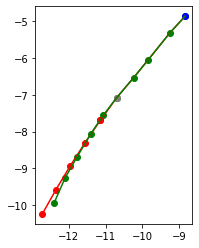

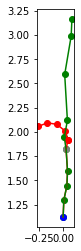

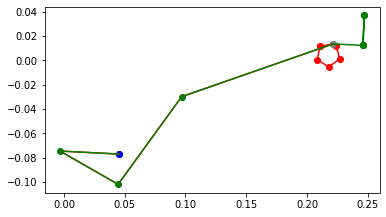

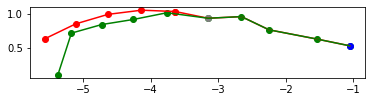

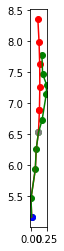

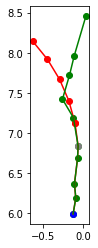

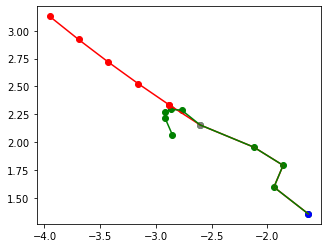

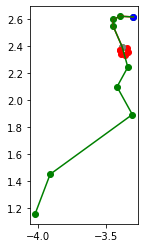

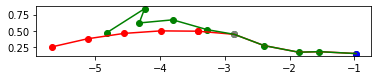

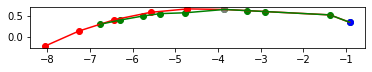

In [59]:
for agent_id in agent_ids[:10]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    pred_x, pred_y, rot_pred_x, rot_pred_y = avg_vel_and_rot_const(sample_x, sample_y, 0.1)
    
    #plot_multiple_trajectories(sample_x, sample_y, test_x, test_y, [pred_x, rot_pred_x], [pred_y, rot_pred_y])
    plot_predictions(sample_x, sample_y, test_x, test_y, rot_pred_x, rot_pred_y)